<a href="https://colab.research.google.com/github/agap03/Projekt3/blob/main/Projekt3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# installing cellcharter
!pip install cellcharter

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.3/161.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━

In [ ]:
import cellcharter as cc
import anndata
import numpy as np

/usr/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [ ]:
# loading data

TRAIN_ANNDATA_PATH = '/content/train_adata.h5ad'

train_anndata = anndata.read_h5ad(TRAIN_ANNDATA_PATH)
train_anndata

AnnData object with n_obs × n_vars = 253433 × 40
    obs: 'image', 'sample_id', 'ObjectNumber', 'Pos_X', 'Pos_Y', 'area', 'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px', 'height_px', 'acquisition_id', 'SlideId', 'Study', 'Box.Description', 'Position', 'SampleId', 'Indication', 'BatchId', 'SubBatchId', 'ROI', 'ROIonSlide', 'includeImage', 'flag_no_cells', 'flag_no_ROI', 'flag_total_area', 'flag_percent_covered', 'small_cell', 'celltypes', 'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos', 'tumor_patches', 'distToCells', 'CD20_patches', 'Batch', 'cell_labels', 'classifier'
    var: 'channel', 'use_channel', 'marker'
    layers: 'exprs'

In [ ]:
# squidpy fromat
import squidpy as sq

train_anndata.obsm['spatial'] = train_anndata.obs[['Pos_X', 'Pos_Y']].values
sq.gr.spatial_neighbors(train_anndata, library_key='sample_id', coord_type='generic', delaunay=True, spatial_key='spatial', percentile=99)

### 1. WARM-UP

In [ ]:
from sklearn.decomposition import PCA

# cells’ marker expressions
expressions = train_anndata.layers['exprs']

# normalizing for PCA
cell_sums = expressions.sum(axis=1, keepdims=True) # finding sum for one cell
normalized = expressions / cell_sums * 1e6 # scale each cell to have total counts = 1e6

# Log1p transformation
normalized = np.log1p(normalized)

train_anndata.layers['exprs_normalized'] = normalized

# PCA that explains 96% of the variance
pca = PCA(n_components=0.95)
expr_pca = pca.fit_transform(normalized)

# storing the PCA-transformed marker expressions
train_anndata.obsm["X_PCA"] = expr_pca

<Figure size 1000x700 with 0 Axes>

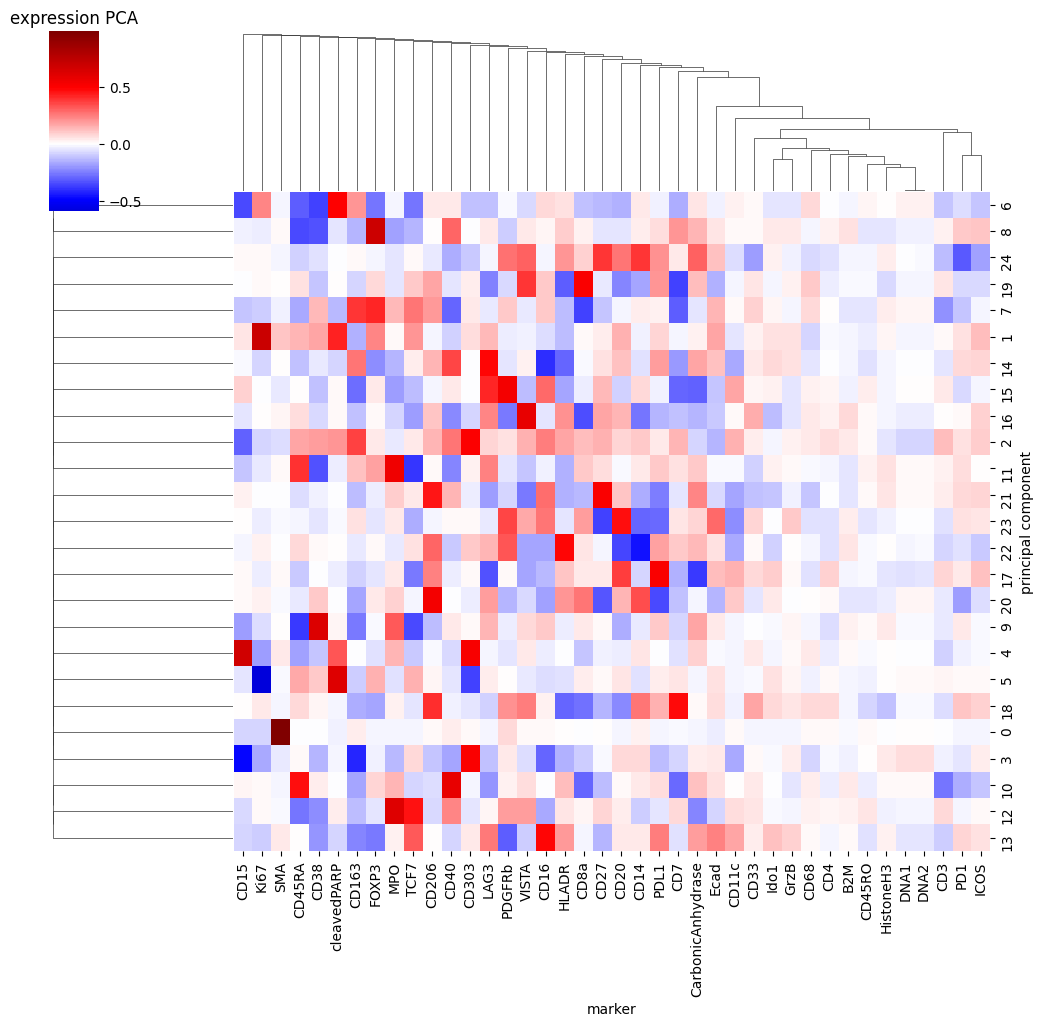

In [ ]:
# visualising PCA

import seaborn as sns
import matplotlib.pyplot as plt

marker_names = train_anndata.var['marker']

plt.figure(figsize = (10, 7))
g = sns.clustermap(pca.components_, center = 0, cmap = 'seismic', xticklabels = marker_names)
g.ax_heatmap.set_xlabel('marker')
g.ax_heatmap.set_ylabel('principal component')
plt.title('expression PCA')
plt.show()

As we can see, different markers contribute differently on the components. Some markers do not have a strong influence on any components and some do on almost all components.

### 2. Neighbor Aggregation

In [ ]:
cc.gr.aggregate_neighbors(train_anndata, n_layers=3, use_rep='X_PCA', out_key='X_cellcharter', sample_key='sample_id')

  0%|          | 0/132 [00:00<?, ?it/s]

n_layers parameter is equal to 3, because that number captures more than just immediate neighbors
but is not too large to loose meaningful local structure. 3 is also used in the tutorial, so it seemed
appropriate to use the same value.

### 3. Cluster Selection

In [ ]:
# defining model parameters
model_params = {
        'random_state': 42,
        'trainer_params': {
            'accelerator':'gpu', # using GPU
            'enable_progress_bar': False
            },
         }

# defining AutoK model to find appropriate number of clusters
models = cc.tl.ClusterAutoK(n_clusters=range(10,30), model_class=cc.tl.GaussianMixture, model_params=model_params, max_runs=5)

In [ ]:
# running AutoK
train_anndata.obsm["X_cellcharter"] = train_anndata.obsm["X_cellcharter"].astype(np.float32) # changing data type to float32
models.fit(train_anndata[::10], use_rep='X_cellcharter') # downsampling by a factor of 10

Iteration 1/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 2/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 3/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 4/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 5/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

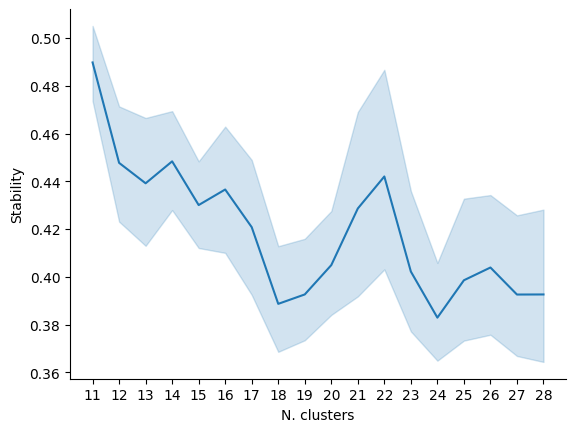

11


In [ ]:
# plotting stability for each number of clusters
cc.pl.autok_stability(models)
plt.show()

# printing best number of clusters
best_k = models.best_k
print(best_k)

In [ ]:
# running prediction with the best number of clusters
train_anndata.obs['cluster_cellcharter'] = models.predict(train_anndata, use_rep='X_cellcharter', k=best_k)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


### 4. Cluster Analysis

<Figure size 1000x700 with 0 Axes>

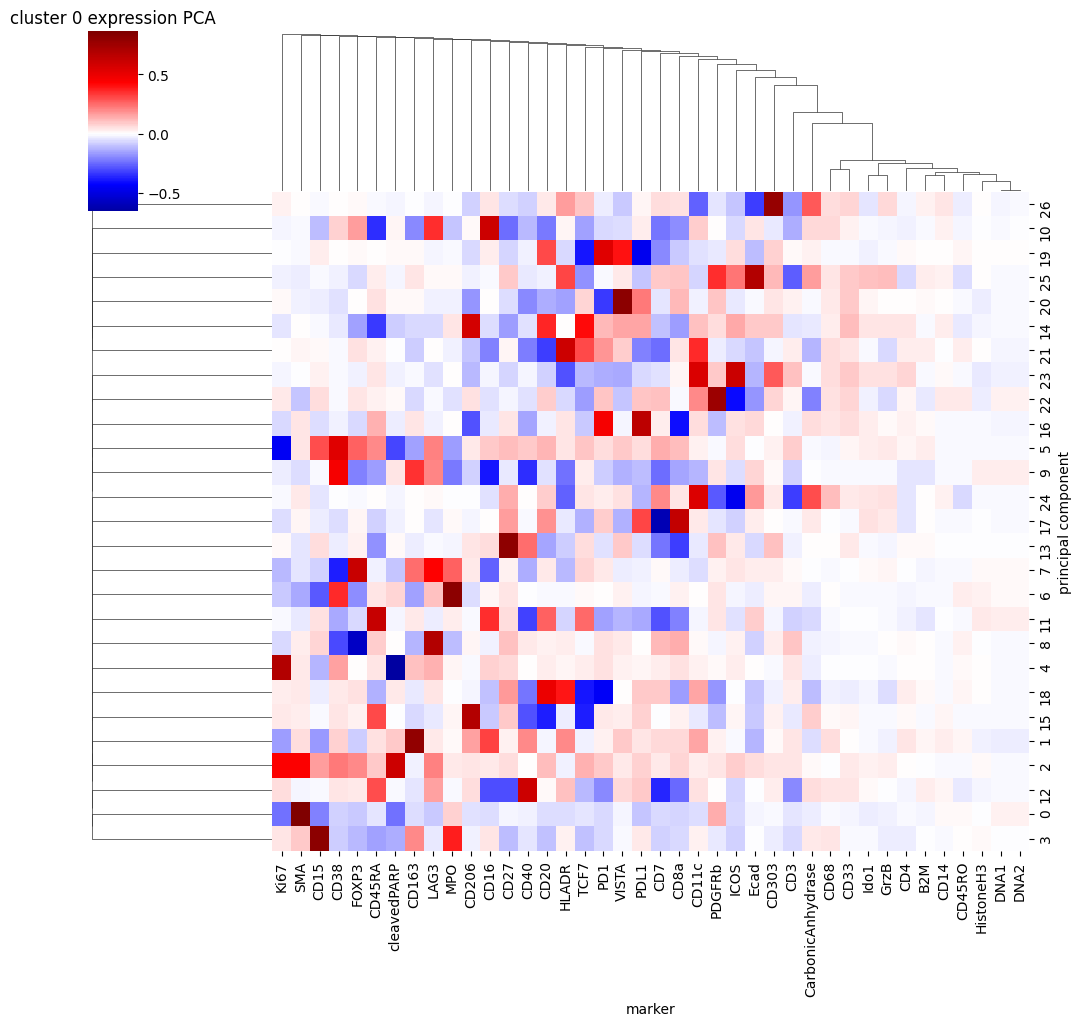

<Figure size 1000x700 with 0 Axes>

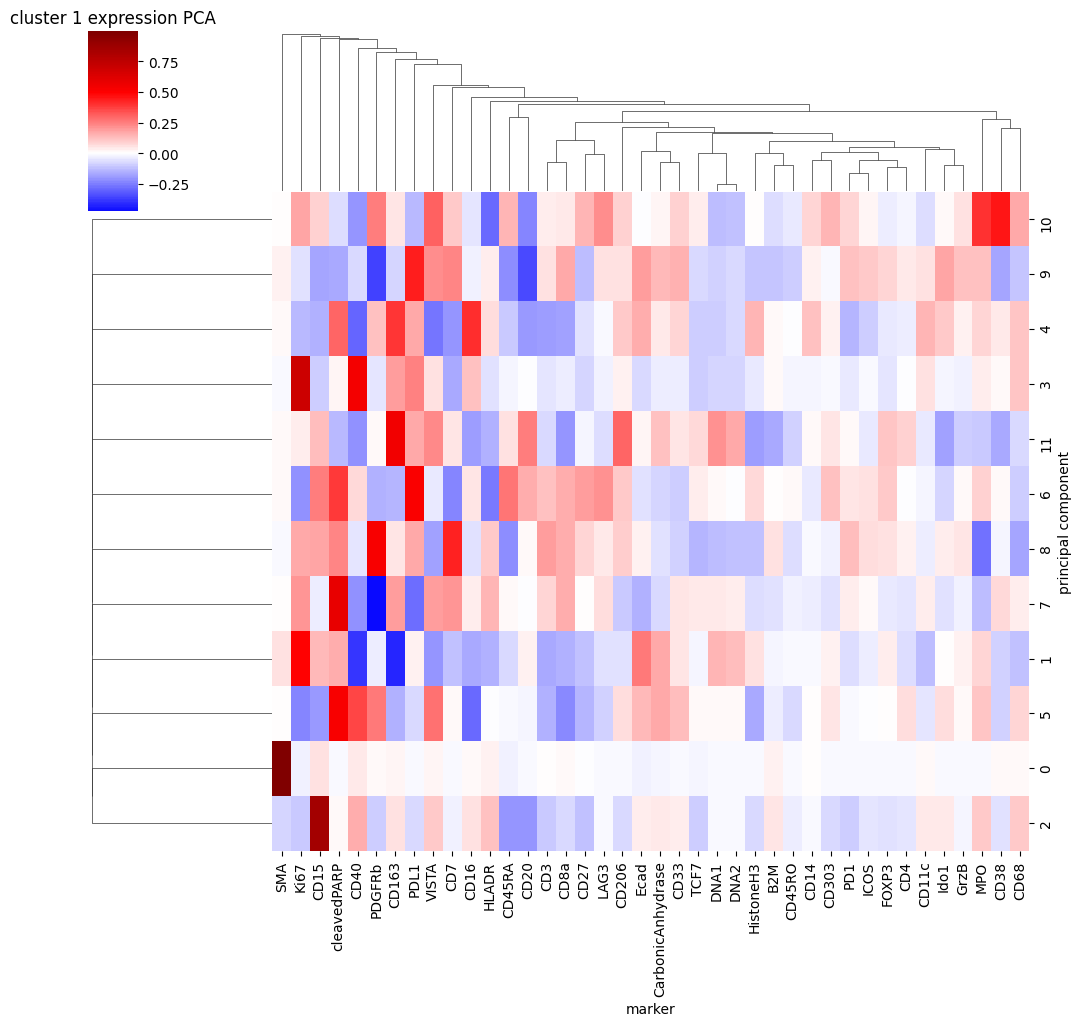

<Figure size 1000x700 with 0 Axes>

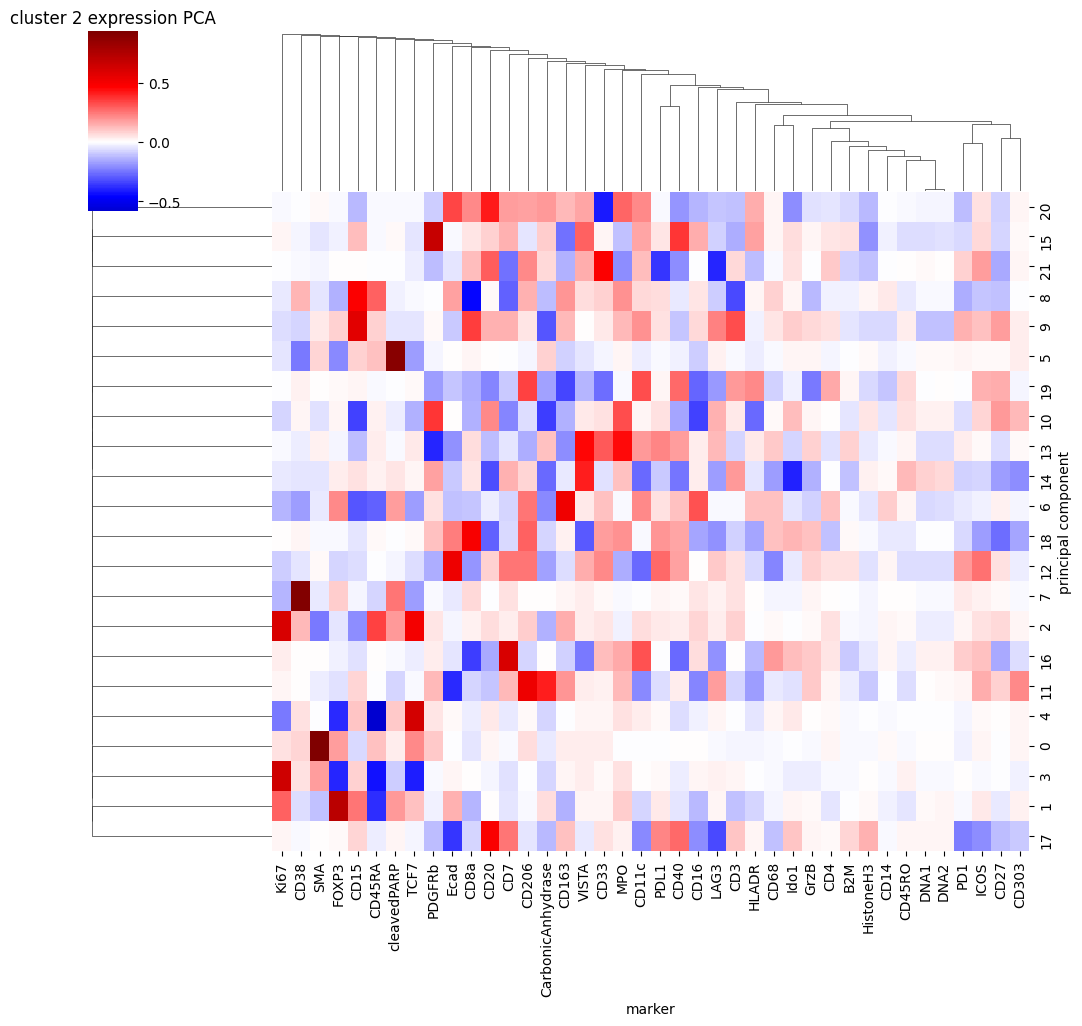

<Figure size 1000x700 with 0 Axes>

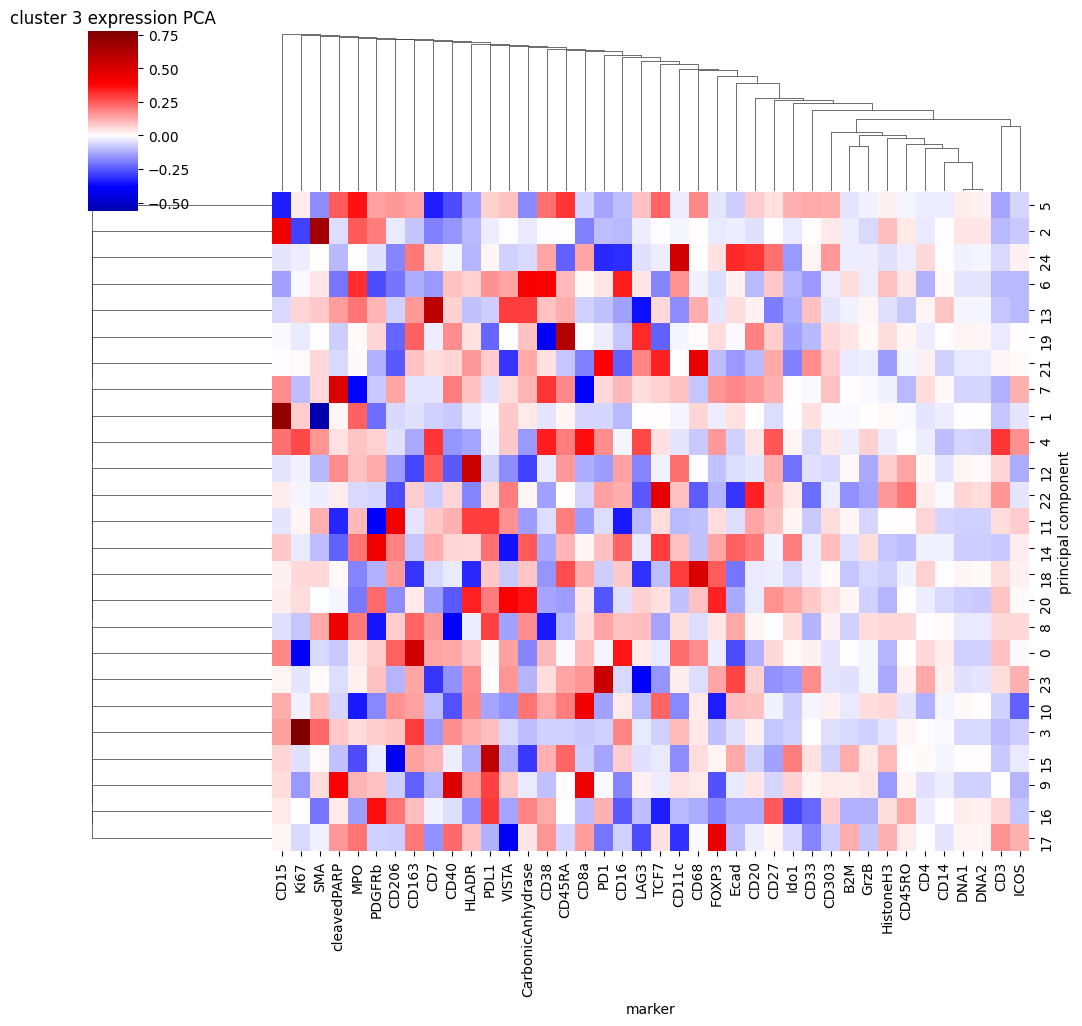

<Figure size 1000x700 with 0 Axes>

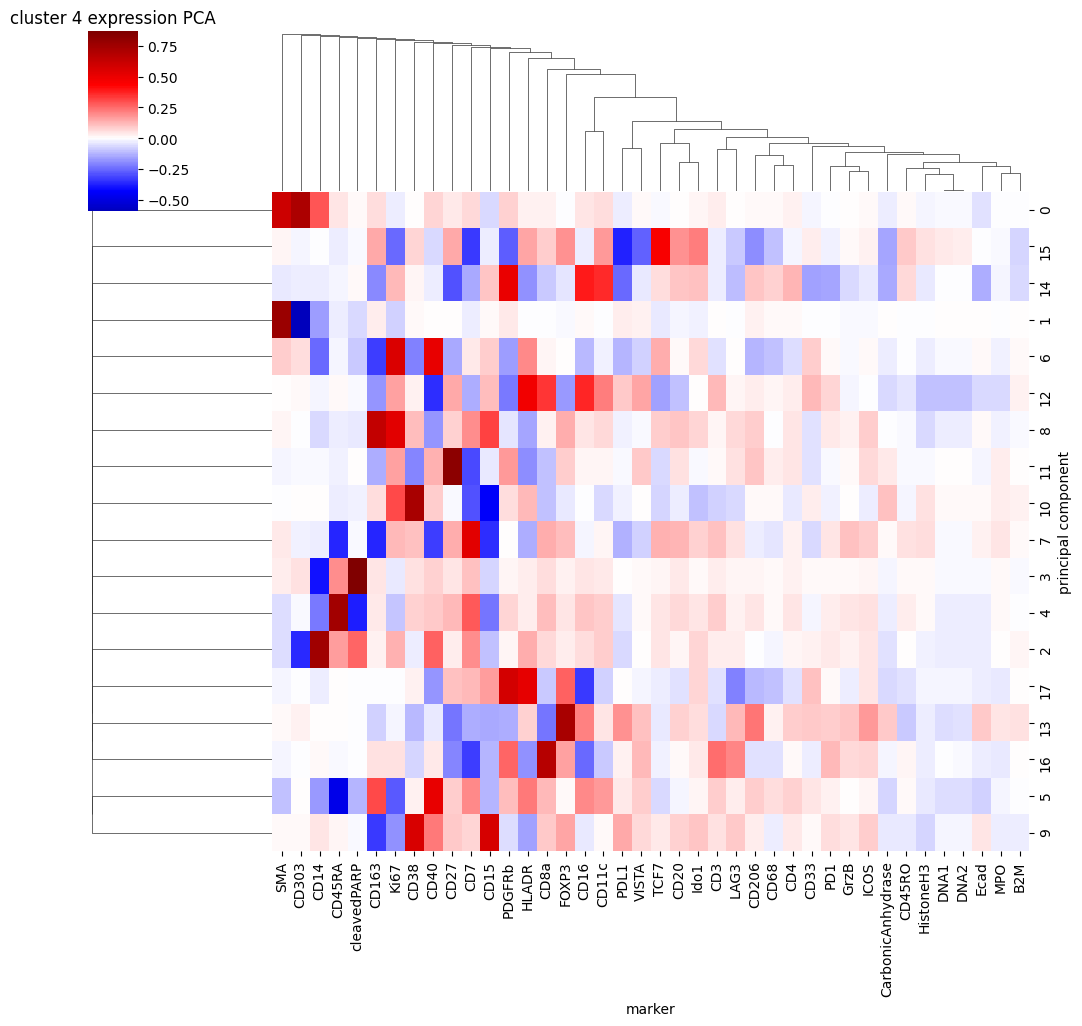

<Figure size 1000x700 with 0 Axes>

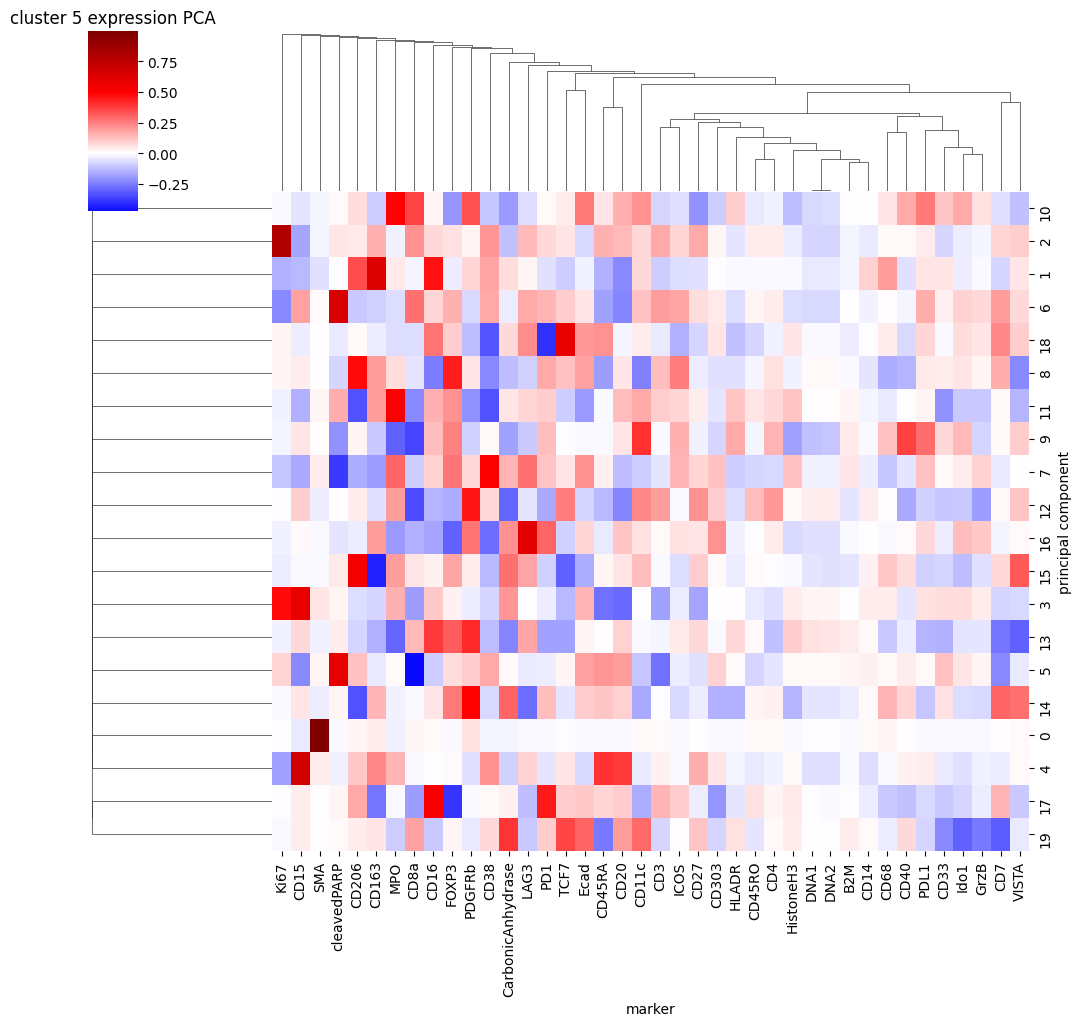

<Figure size 1000x700 with 0 Axes>

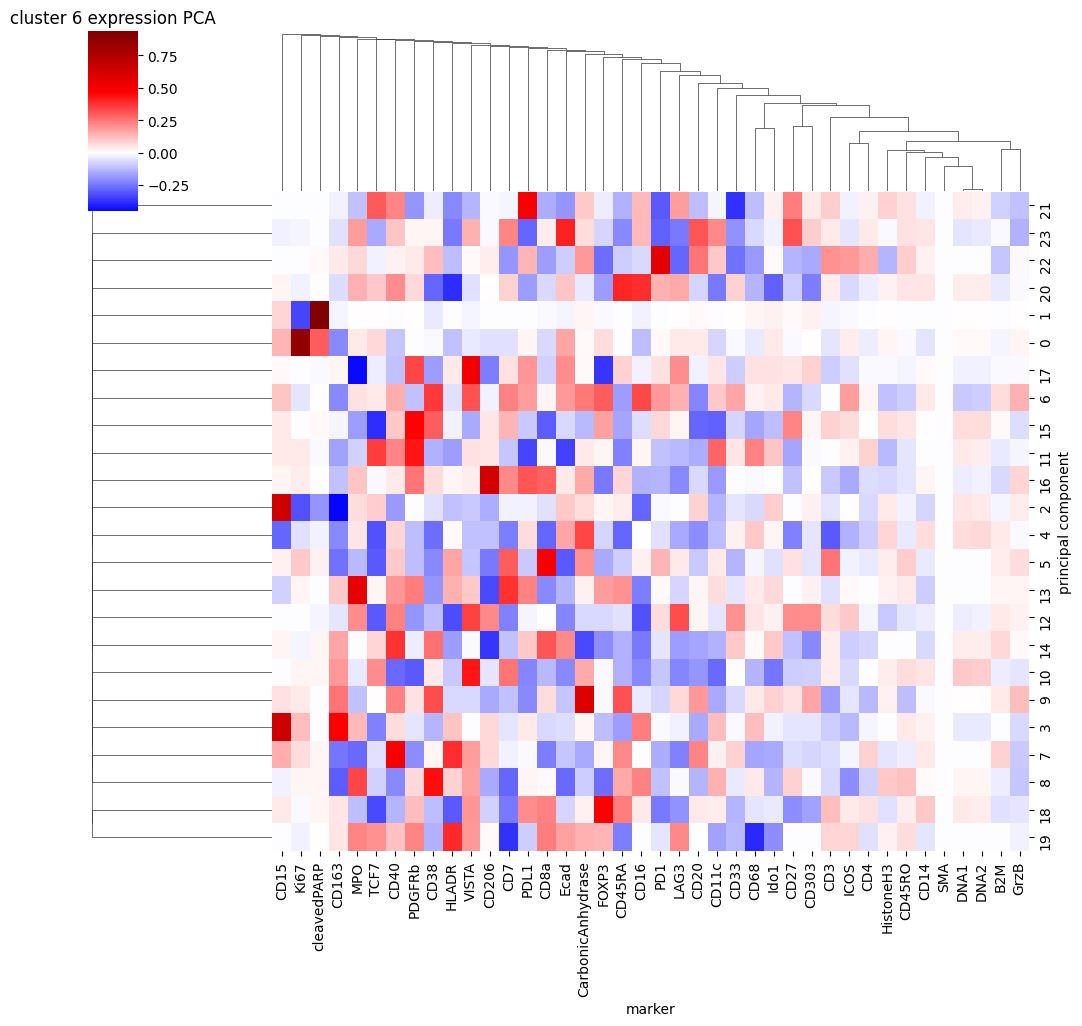

<Figure size 1000x700 with 0 Axes>

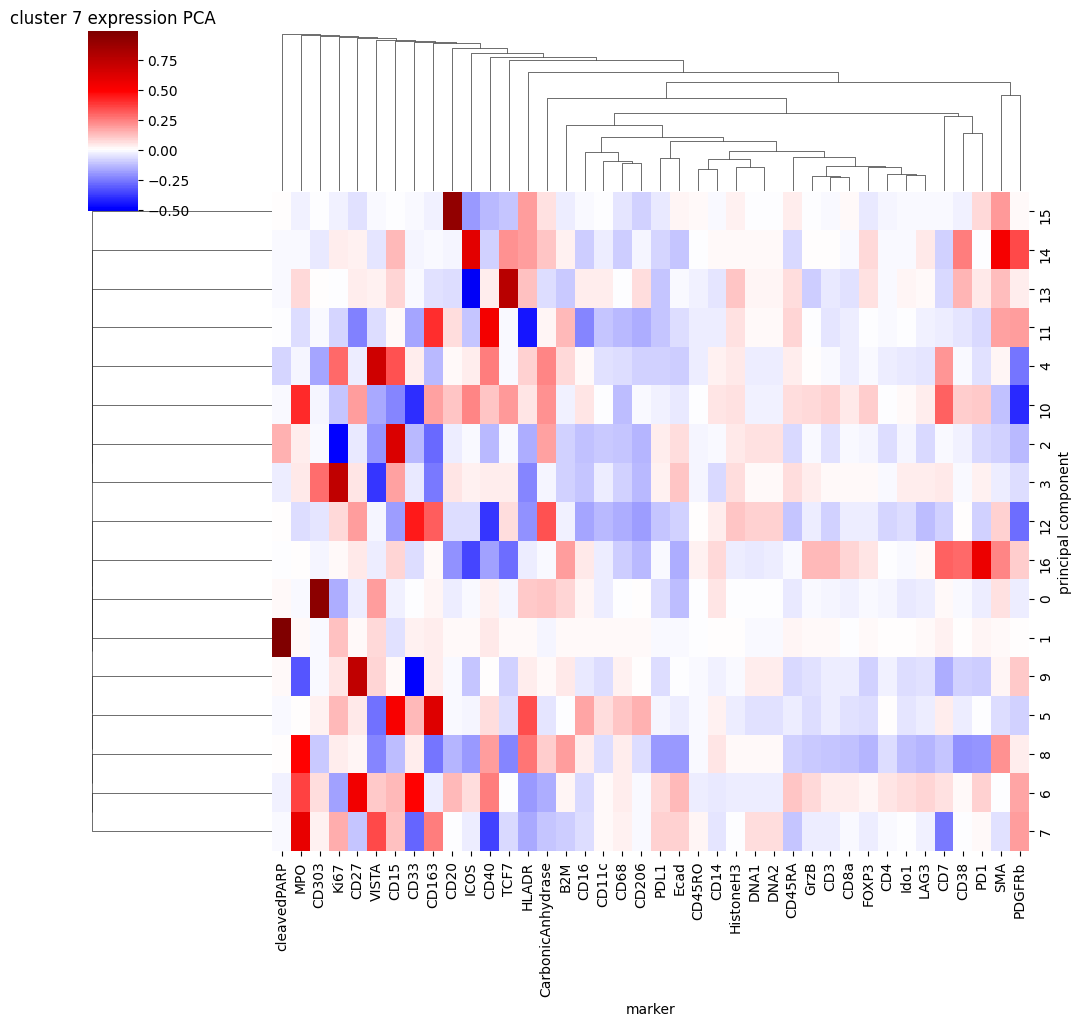

<Figure size 1000x700 with 0 Axes>

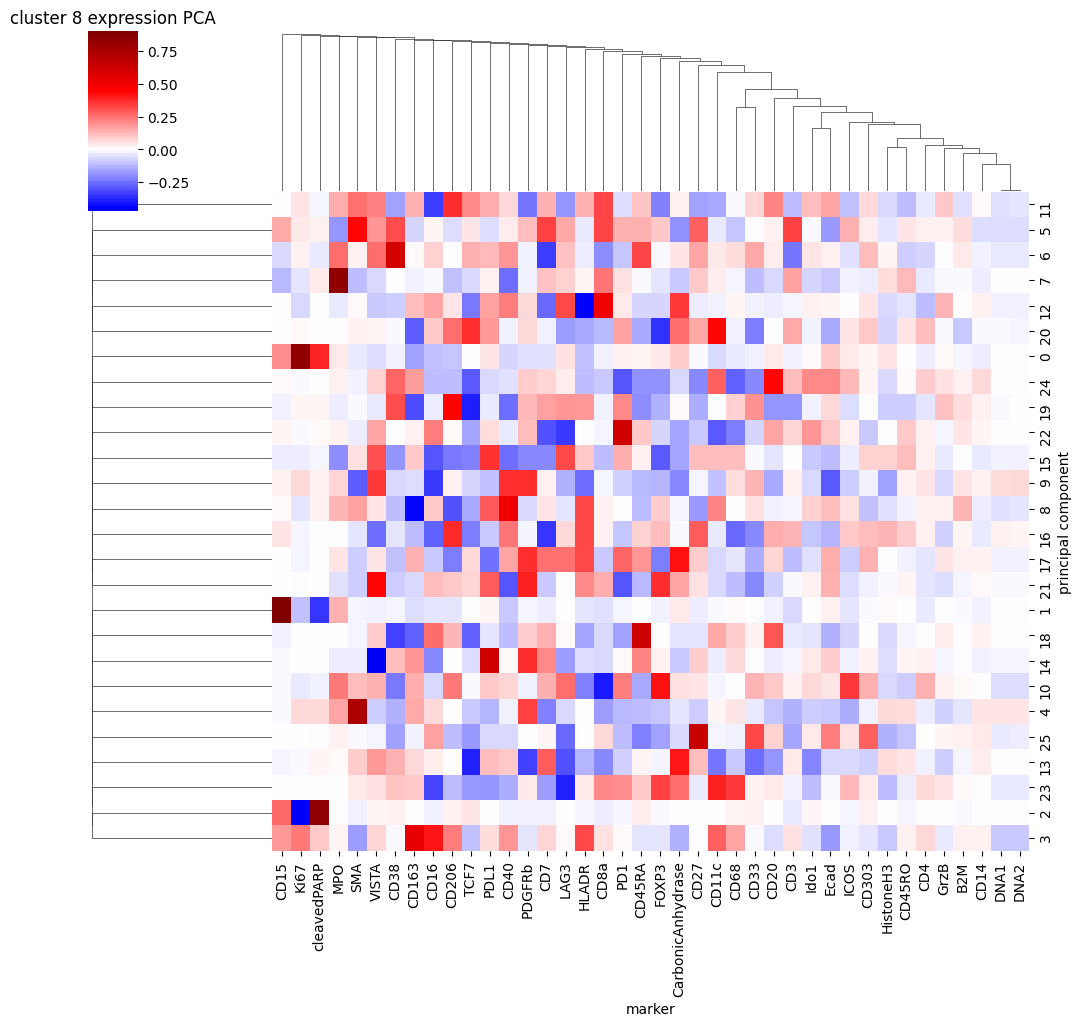

<Figure size 1000x700 with 0 Axes>

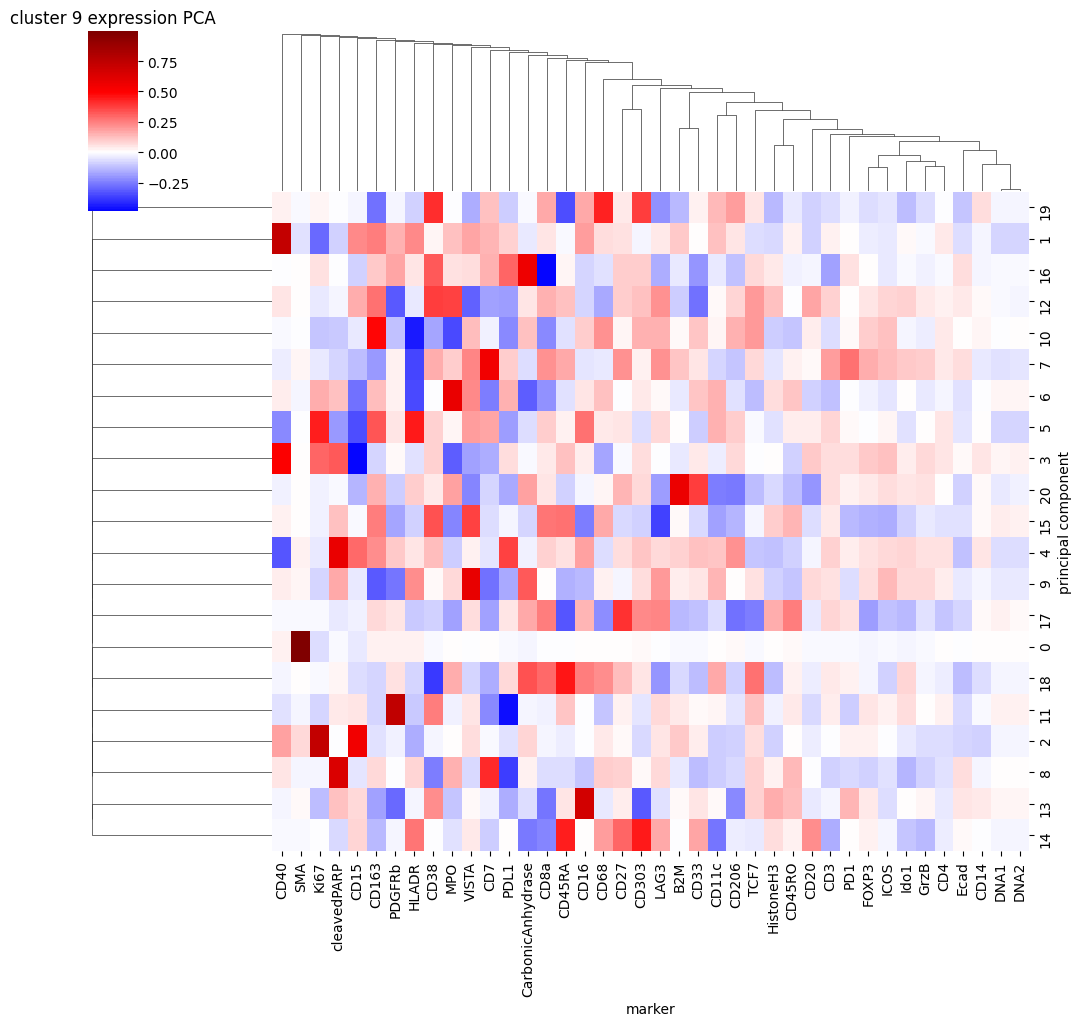

<Figure size 1000x700 with 0 Axes>

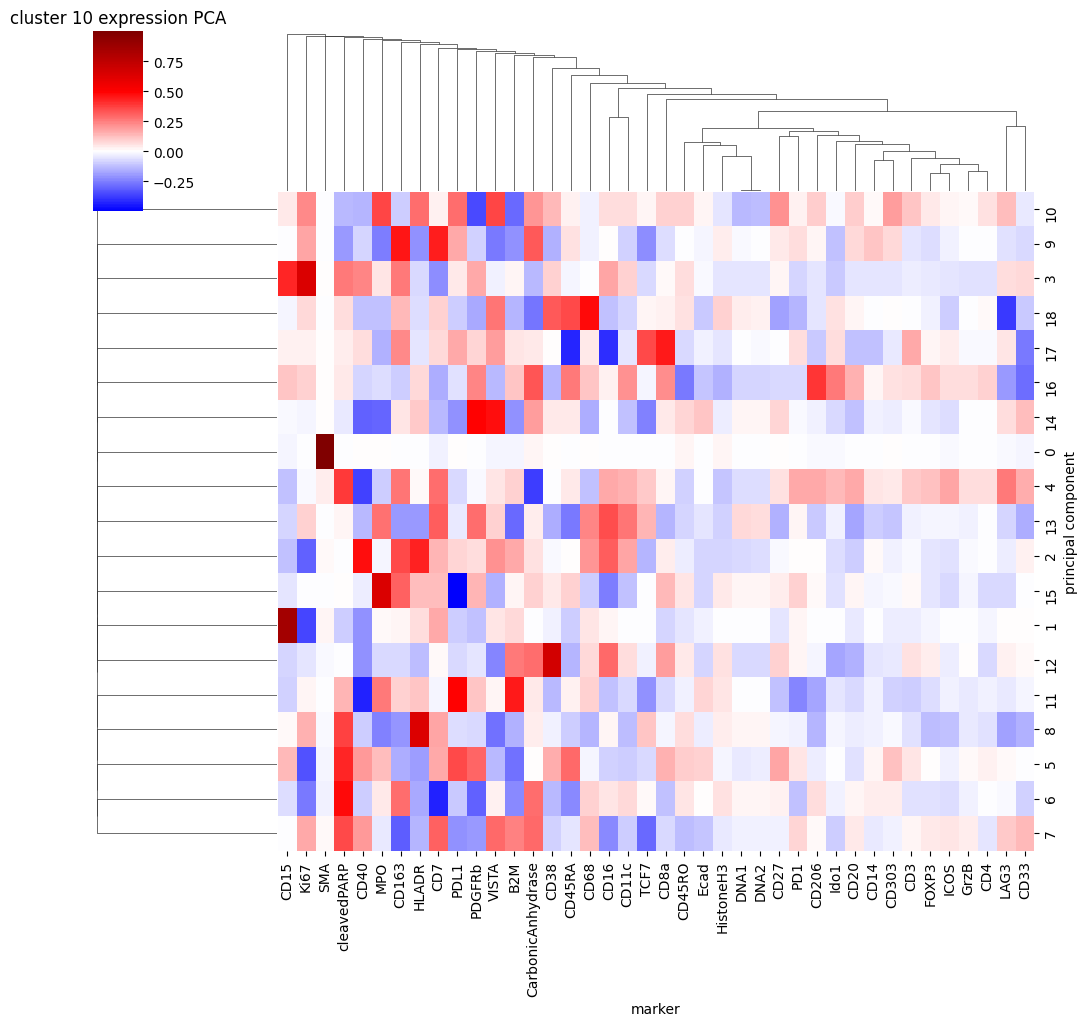

In [ ]:
# PCA

# This analysis will be done on marker expression (after normalization) for a single cell,
# without including neighbor aggregation.
# I want to visualize differences in cells based on their own expression profiles,
# even though clustering was performed with regard to local environment.

for i in range(best_k):

    # cluster i
    mask = train_anndata.obs['cluster_cellcharter'] == i
    cluster_PCA = train_anndata.layers['exprs_normalized'][mask, :]

    # PCA that explains 96% of the variance
    pca = PCA(n_components=0.95)
    expr_clust_pca = pca.fit_transform(cluster_PCA)


    # visualising PCA

    plt.figure(figsize = (10, 7))
    g = sns.clustermap(pca.components_, center = 0, cmap = 'seismic', xticklabels = marker_names)
    g.ax_heatmap.set_xlabel('marker')
    g.ax_heatmap.set_ylabel('principal component')
    plt.title(f'cluster {i} expression PCA')
    plt.show()


As we can see different markers are more important in different clusters and contribute differently to each component.

<ipython-input-30-e21bf39a3ca3>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_abundance = train_anndata.obs.groupby('cluster_cellcharter')['celltypes'].value_counts(normalize=True).unstack() # normalizzed


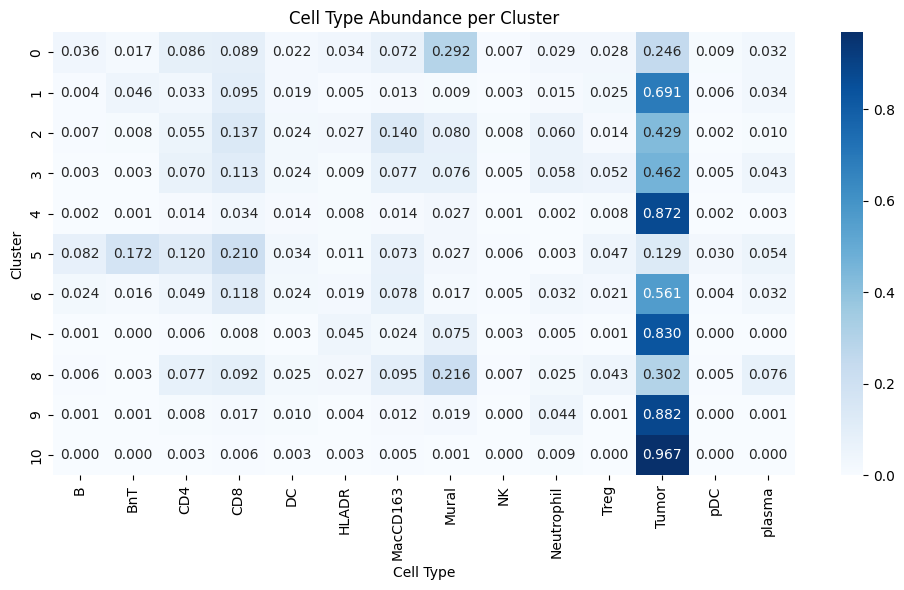

In [ ]:
# cell type abundance for every cluster
cell_type_abundance = train_anndata.obs.groupby('cluster_cellcharter')['celltypes'].value_counts(normalize=True).unstack() # normalized

# plot
plt.figure(figsize=(10,6))
sns.heatmap(cell_type_abundance, annot=True, fmt=".3f", cmap="Blues")
plt.title("Cell Type Abundance per Cluster")
plt.xlabel("Cell Type")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In every cluster prevalent cell type is Tumor. It is understandable since the samples are from cancer patients. To visualise cell abundance apart from tumor, the analysys will be repeated without tumor cells:

<ipython-input-59-c2b284e67837>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_abundance = train_anndata.obs.groupby('cluster_cellcharter')['celltypes'].value_counts().unstack()


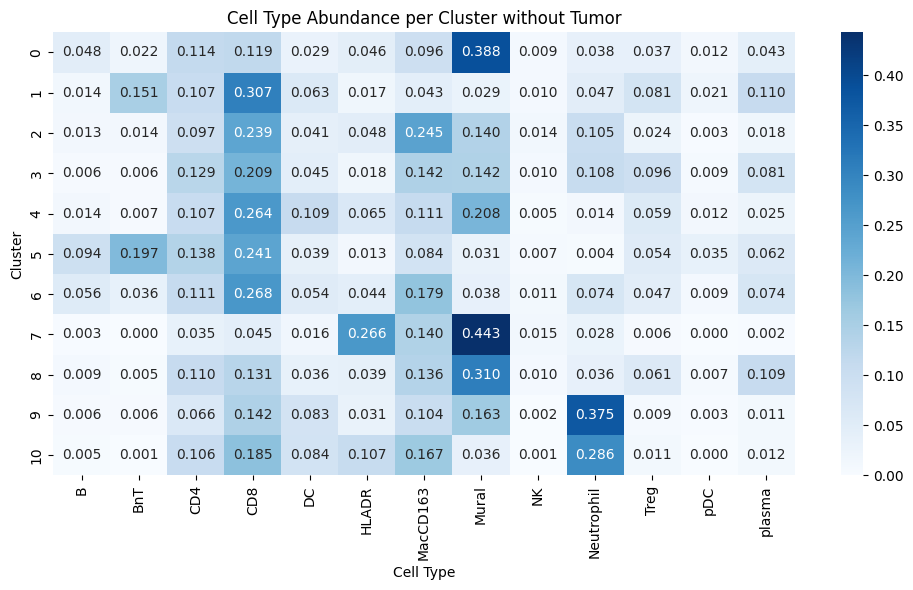

In [ ]:
# cell type abundance for every cluster
cell_type_abundance = train_anndata.obs.groupby('cluster_cellcharter')['celltypes'].value_counts().unstack()

# dropping 'Tumor'
cell_type_abundance.drop(columns=['Tumor'], inplace=True)

# normalizing
cell_type_abundance = cell_type_abundance.div(cell_type_abundance.sum(axis=1), axis=0)

# plot
plt.figure(figsize=(10,6))
sns.heatmap(cell_type_abundance, annot=True, fmt=".3f", cmap="Blues")
plt.title("Cell Type Abundance per Cluster without Tumor")
plt.xlabel("Cell Type")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

Thanks to that representation, we can see more clearly in which clusters which immune cells are more active. For example Mural cells are aboundant in clusters 0, 7 and 8, while Neutrophils are abundant in clusters 9 and 10.

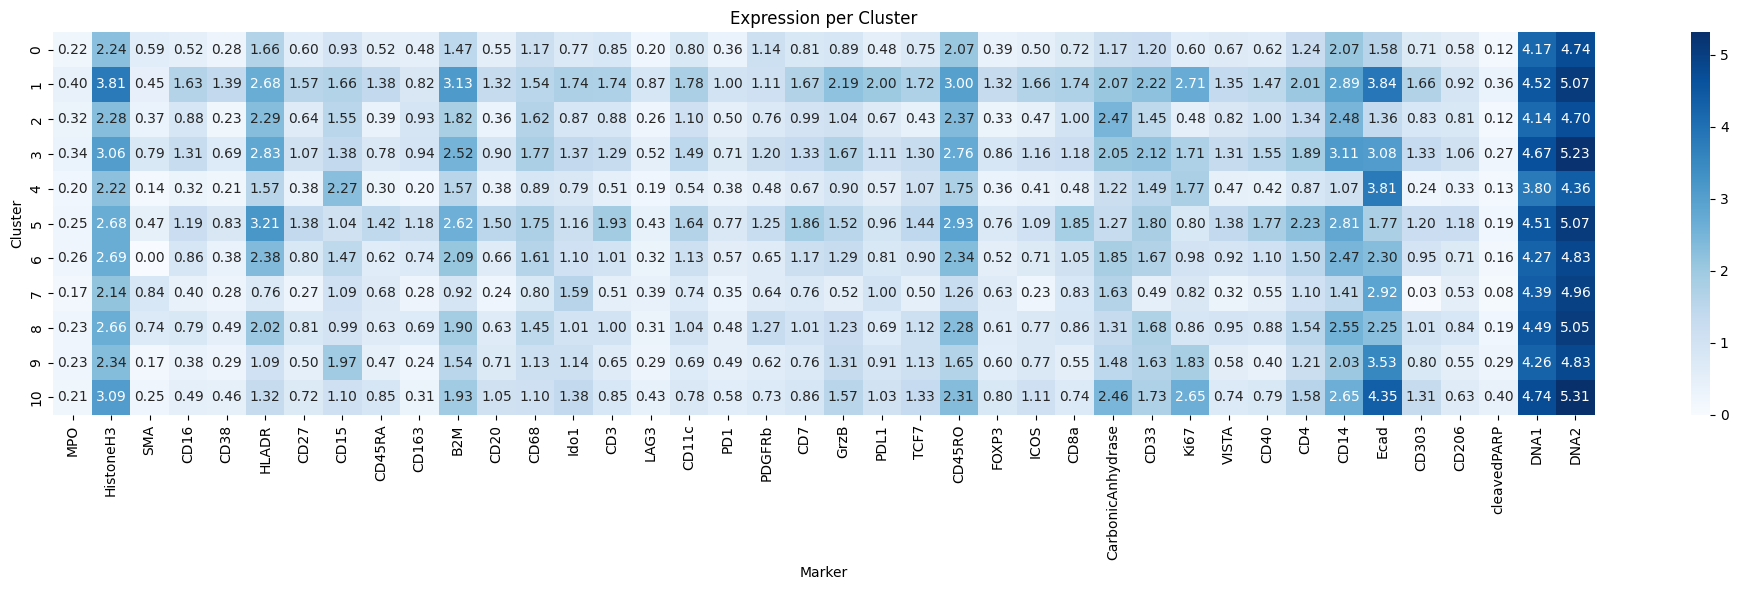

In [ ]:
# mean marker expression for each cluster

expressions_clusters = []

for i in range(best_k):

    # cluster i
    mask = train_anndata.obs['cluster_cellcharter'] == i
    cluster_expression = train_anndata.layers['exprs'][mask, :]

    # mean expression for cluster
    avg_expression = cluster_expression.mean(axis=0)

    expressions_clusters.append(avg_expression)

# merge everything
expressions_clusters = np.stack(expressions_clusters)

import pandas as pd

# change to DataFrame
expressions_clusters_df = pd.DataFrame(
    expressions_clusters,
    columns=marker_names, # marker names as columns
    index=[f'{i}' for i in range(best_k)]  # cluster names as rows
)


# plot
plt.figure(figsize=(20,6))
sns.heatmap(expressions_clusters_df, annot=True, fmt=".2f", cmap="Blues")
plt.title("Expression per Cluster")
plt.xlabel("Marker")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

Here we can see which markers are the most expressed in each cluster. We can notice for example that markers DNA1 and DN2 are highly expressed in every cluster, while for example HLADR is highly expressed in cluster 5 and poorly expressed in cluster 7.

### 5. Cross-count Matrices

In [ ]:
# clustering for mean marker and cell type histogram done earlier during classes


# finding mean marker expression
avg_marker_expression = []
for i in range(len(train_anndata.obs)):

  # finding neighbors
  neighbors = train_anndata.obsp['spatial_connectivities'][i].indices

  # adding yourself as a neighbor
  neighbors_lis=list(neighbors)
  neighbors_lis.append(i)
  neighbors=np.array(neighbors_lis)

  # finding mean expression in neighbors
  avg_expression = np.mean(train_anndata.layers['exprs'][neighbors], axis=0)
  avg_marker_expression.append(avg_expression)

# merging results
avg_marker_expression = np.stack(avg_marker_expression)


# finding cell types histograms

# creating onehots where each cell has a 1 in column of its celltype
train_anndata.obs['dummy'] = 1
cell_type_onehots=pd.pivot_table(train_anndata.obs, values='dummy', index=train_anndata.obs.index, columns=['celltypes'], aggfunc=np.sum)
cell_type_onehots=cell_type_onehots.loc[train_anndata.obs.index] # fixing the order


neigh_hist = []
for i in range(len(train_anndata.obs)):

  # finding neighbors
  neighbors = train_anndata.obsp['spatial_connectivities'][i].indices

  # adding yourself as a neighbor
  neighbors_lis=list(neighbors)
  neighbors_lis.append(i)
  neighbors=np.array(neighbors_lis)

  # summing cell types
  sum_neigh = np.sum(cell_type_onehots.values[neighbors], axis=0)
  neigh_hist.append(sum_neigh)

# merging results
neigh_hist = np.stack(neigh_hist)

# enriching data
train_anndata.obsm['avg_marker_expression'] = avg_marker_expression
train_anndata.obsm['cell_type_hist'] = neigh_hist

# models for clustering with finding best number of clusters
models_avg_expr = cc.tl.ClusterAutoK(n_clusters=range(10,30), model_class=cc.tl.GaussianMixture, model_params=model_params, max_runs=5)
models_cell_type_hist = cc.tl.ClusterAutoK(n_clusters=range(10,30), model_class=cc.tl.GaussianMixture, model_params=model_params, max_runs=5)

train_anndata.obsm["avg_marker_expression"] = train_anndata.obsm["avg_marker_expression"].astype(np.float32)
models_avg_expr.fit(train_anndata[::10], use_rep='avg_marker_expression')

train_anndata.obsm["cell_type_hist"] = train_anndata.obsm["cell_type_hist"].astype(np.float32)
models_cell_type_hist.fit(train_anndata[::10], use_rep='cell_type_hist')

n_clusters_avg_expr = models_avg_expr.best_k
n_clusters_hist = models_cell_type_hist.best_k

# running predictions

train_anndata.obs['cluster_marker'] = models_avg_expr.predict(train_anndata, use_rep='avg_marker_expression', k=n_clusters_avg_expr)
train_anndata.obs['cluster_hist'] = models_cell_type_hist.predict(train_anndata, use_rep='cell_type_hist', k=n_clusters_hist)


<ipython-input-64-4e518f2380c2>:31: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  cell_type_onehots=pd.pivot_table(train_anndata.obs, values='dummy', index=train_anndata.obs.index, columns=['celltypes'], aggfunc=np.sum)
<ipython-input-64-4e518f2380c2>:31: FutureWarning: The provided callable <function sum at 0x781b16b8e7a0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cell_type_onehots=pd.pivot_table(train_anndata.obs, values='dummy', index=train_anndata.obs.index, columns=['celltypes'], aggfunc=np.sum)


Iteration 1/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 2/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 3/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 4/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 5/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 1/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 2/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 3/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 4/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 5/5


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

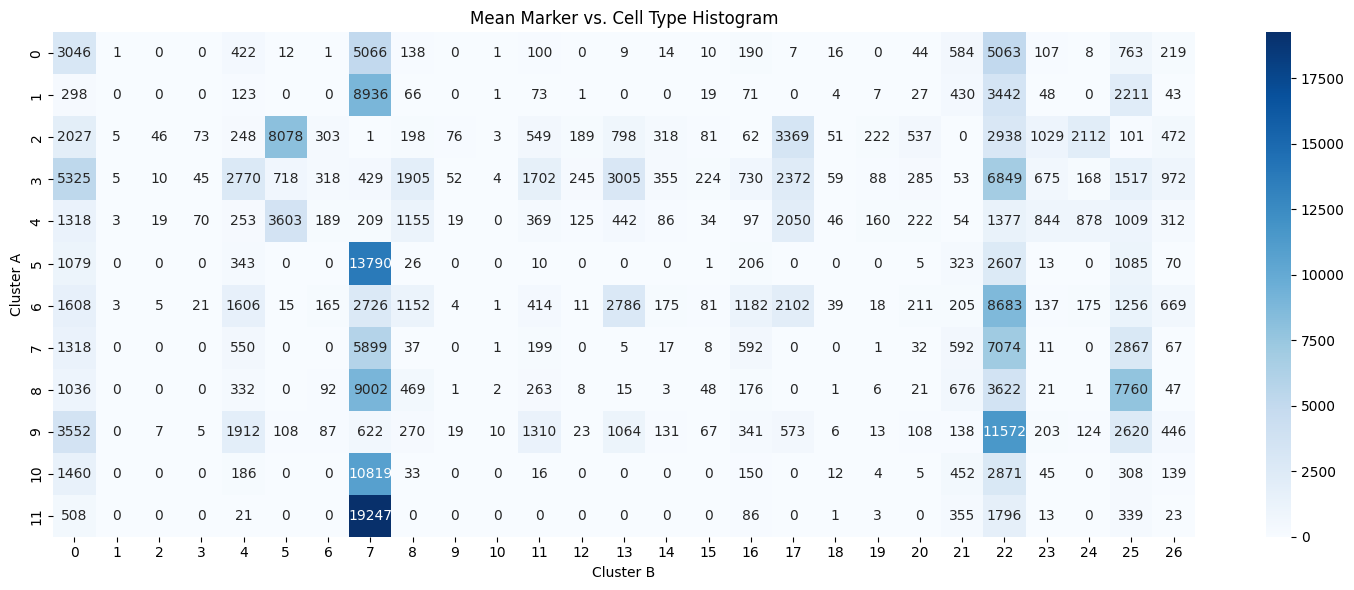

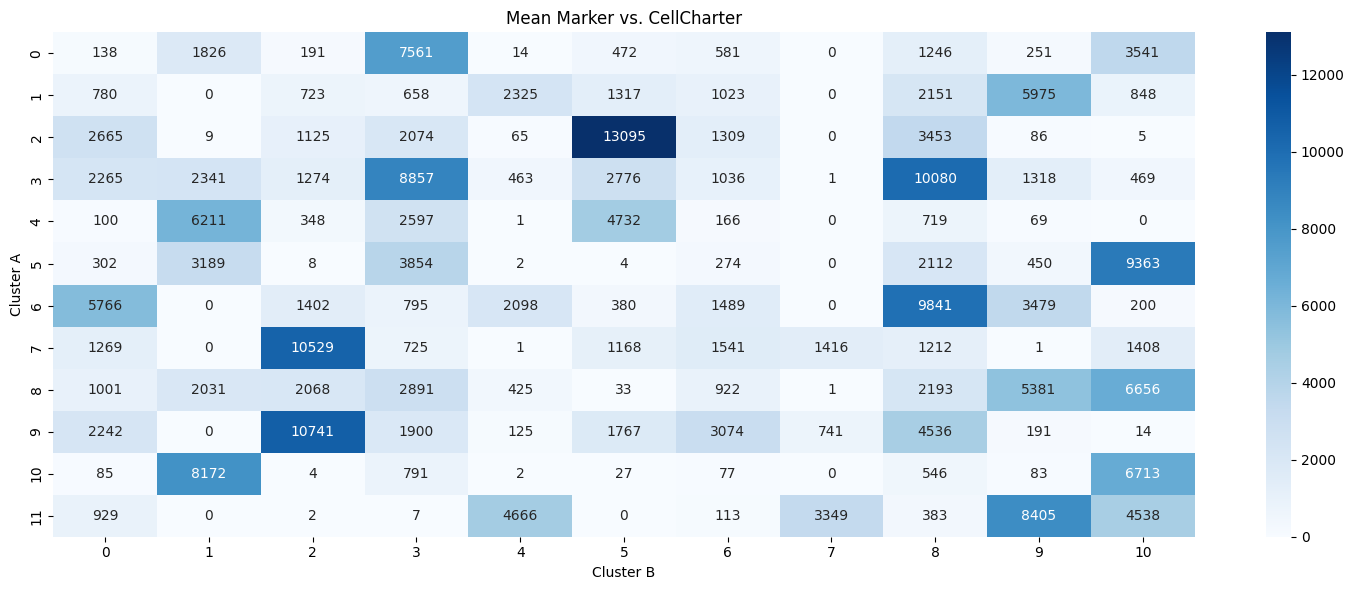

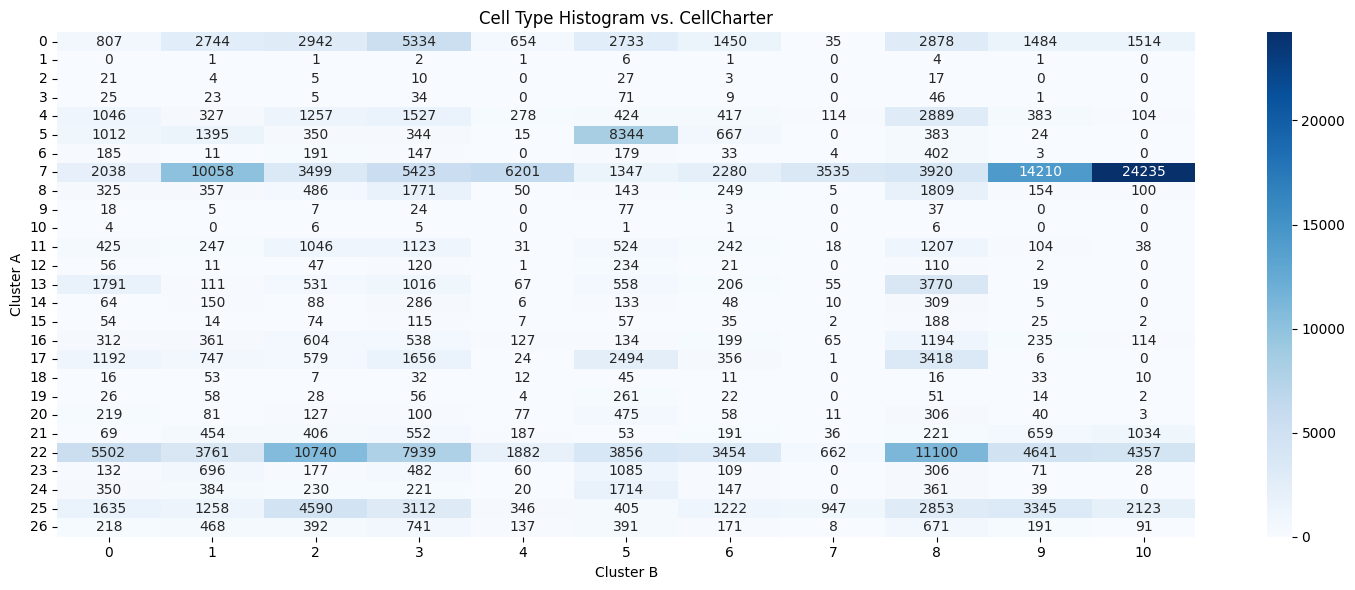

In [ ]:
# Mean marker vs. Cell type histogram
cross1 = pd.crosstab(train_anndata.obs['cluster_marker'],
                     train_anndata.obs['cluster_hist'])

# Mean marker vs. CellCharter
cross2 = pd.crosstab(train_anndata.obs['cluster_marker'],
                     train_anndata.obs['cluster_cellcharter'])

# Cell type histogram vs. CellCharter
cross3 = pd.crosstab(train_anndata.obs['cluster_hist'],
                     train_anndata.obs['cluster_cellcharter'])

# visualising
def plot_heatmap(cross_tab, title):
    plt.figure(figsize=(15, 6))
    sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Cluster B')
    plt.ylabel('Cluster A')
    plt.tight_layout()
    plt.show()

plot_heatmap(cross1, "Mean Marker vs. Cell Type Histogram")
plot_heatmap(cross2, "Mean Marker vs. CellCharter")
plot_heatmap(cross3, "Cell Type Histogram vs. CellCharter")

Ususally the clusters between methods do not allign very well. However, there are a few that are similar.
In case of Mean Marker vs. Cell Type Histogram cluster 7 from histogram is similar to clusters 5, 10 and 11 from mean marker.
Also cluster 22 from histogram is similar to cluster 9 from mean marker. The rest of clusters are not matching to each other.
It suggests that cell types and mean expression in meighbors might influeance each other, but only in a few cases.

Matrix Mean Marker vs. CellCharter shows a little more similarities, but still not ideal. The strongest agreement appears
between cluster 5 from Cellcharter and cluster 2 from mean marker. Overall moderate allignment suggests that similar patterns.

Cell Type Histogram vs. CellCharter also does not have a lot of similar clusters, but there are a few (like cluster 10 from Cellcharter
adnd cluster 7 from histogram) that are well-aligned. It suggests that there is some correlation between cell types and marker expression
counted with Cellcharter, but it exists only in a few cases.